In [1]:
%matplotlib inline

import glob
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio as im
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
#! pip install ibm-cos-sdk
import ibm_boto3
from botocore.client import Config, ClientError
import types

In [3]:
#COS 인증정보 정의
IAM_SERVICE_ID= 'ServiceId-b5855f48-8bc3-4850-9635-9ed6e57f3f59'
IBM_API_KEY_ID='cXU9zBUwR1zcaKkcWBhxzfsafaY3V1wEv1o8uJOm4epA'
#IBM_API_KEY_ID='D-rPayJnbJj_q8aNEkCTIsU887Rzf_CP_q_wN8l59IOD'
ENDPOINT='https://s3.us.cloud-object-storage.appdomain.cloud'
IBM_AUTH_ENDPOINT= 'https://iam.ng.bluemix.net/oidc/token'
BUCKET='shapescan-donotdelete-pr-mgsuxvobpleqer'
COS_RESOURCE_CRN = "crn:v1:bluemix:public:cloud-object-storage:global:a/8d8f8f9cfc6fdd0b99e9f328b47ee768:855afe22-c6b1-4707-b1bf-23e1fcd64748::"

In [4]:
# Create resource
s3 = ibm_boto3.resource("s3",
    ibm_api_key_id=IBM_API_KEY_ID,
    ibm_service_instance_id=COS_RESOURCE_CRN,
    ibm_auth_endpoint=IBM_AUTH_ENDPOINT,
    config=Config(signature_version="oauth"),
    endpoint_url=ENDPOINT
)

In [5]:
!ls -l

total 0


In [6]:
#다운로드 입력 파일
s3.Object(BUCKET, 'shapes.zip').download_file('shapes.zip')

In [7]:
!ls -l

total 308
-rw-r----- 1 dsxuser dsxuser 315291 May 18 07:26 shapes.zip


In [8]:
! unzip -o shapes.zip

Archive:  shapes.zip
   creating: training_set/
  inflating: training_set/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/training_set/
  inflating: __MACOSX/training_set/._.DS_Store  
   creating: training_set/circles/
  inflating: training_set/circles/drawing(48).png  
   creating: __MACOSX/training_set/circles/
  inflating: __MACOSX/training_set/circles/._drawing(48).png  
  inflating: training_set/circles/drawing(33).png  
  inflating: __MACOSX/training_set/circles/._drawing(33).png  
  inflating: training_set/circles/drawing(64).png  
  inflating: __MACOSX/training_set/circles/._drawing(64).png  
  inflating: training_set/circles/drawing(25).png  
  inflating: __MACOSX/training_set/circles/._drawing(25).png  
  inflating: training_set/circles/drawing(52).png  
  inflating: __MACOSX/training_set/circles/._drawing(52).png  
  inflating: training_set/circles/drawing(7).png  
  inflating: __MACOSX/training_set/circles/._drawing(7).png  
  inflating: training_set/circles/drawi

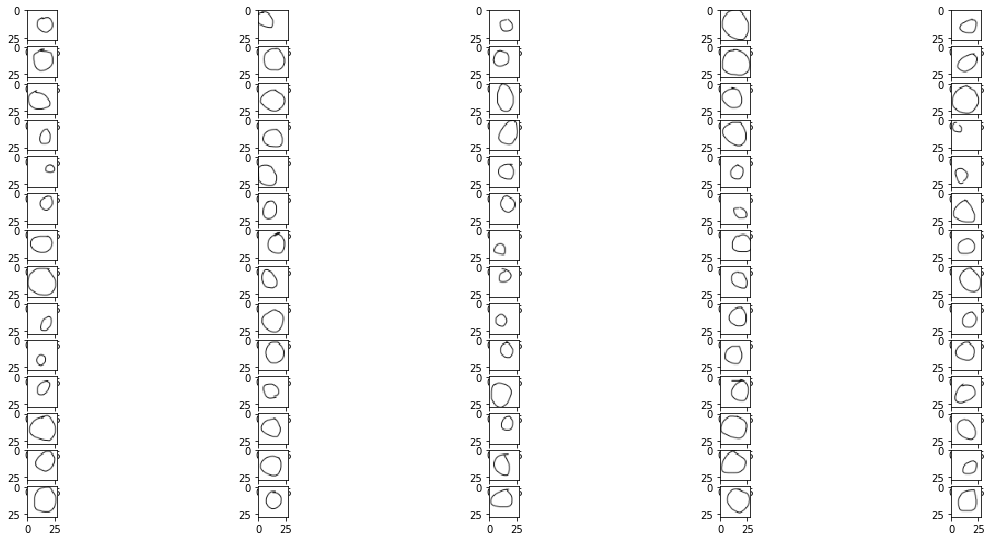

In [9]:
images = []
for img_path in glob.glob('training_set/circles/*.png'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 5
for i, image_circle in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image_circle)

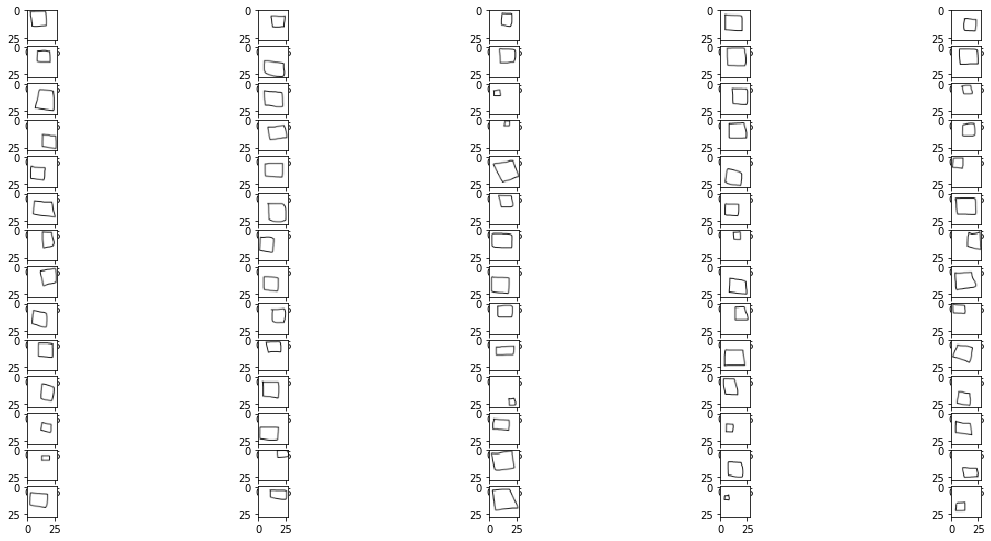

In [10]:
images = []
for img_path in glob.glob('training_set/squares/*.png'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 5
for i, image_square in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image_square)

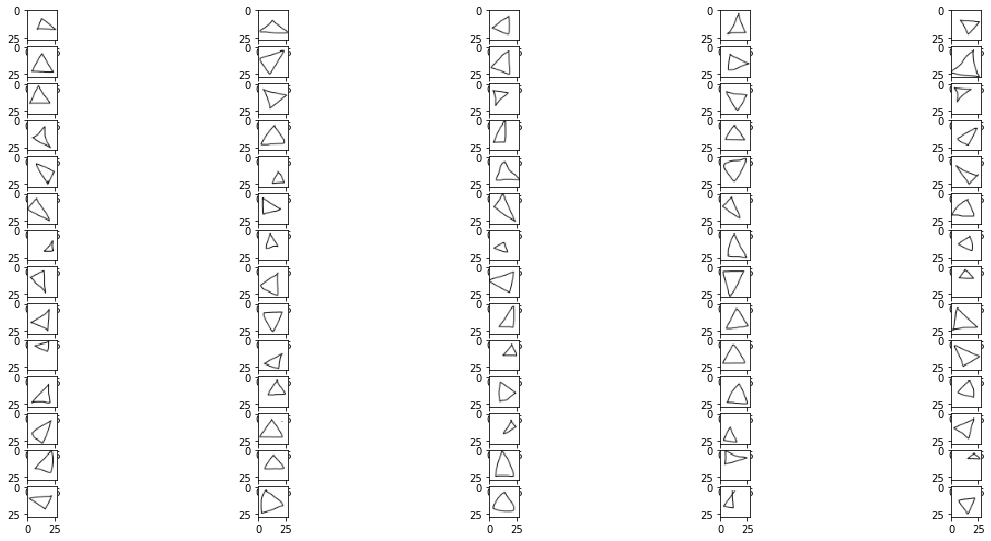

In [11]:
images = []
for img_path in glob.glob('training_set/triangles/*.png'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 5
for i, image_triangle in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image_triangle)

In [12]:
img = im.imread('training_set/squares/drawing(40).png')
img.shape

(28, 28, 3)

In [13]:
classifier = Sequential()

In [14]:
classifier.add(Conv2D(32, (3, 3), padding='same', input_shape = (28, 28, 3), activation = 'relu'))
classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5)) # antes era 0.25

# Adding a second convolutional layer
classifier.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5)) # antes era 0.25

# Adding a third convolutional layer
classifier.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5)) # antes era 0.25

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 512, activation = 'relu'))
classifier.add(Dropout(0.5)) 
classifier.add(Dense(units = 3, activation = 'softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
classifier.compile(optimizer = 'rmsprop',
                   loss = 'categorical_crossentropy', 
                   metrics = ['accuracy'])

In [16]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('training_set',
                                                 target_size = (28, 28),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('test_set',
                                            target_size = (28, 28),
                                            batch_size = 16,
                                            class_mode = 'categorical')

Found 210 images belonging to 3 classes.
Found 87 images belonging to 3 classes.


In [17]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", 
                               monitor = 'val_acc',
                               verbose=1, 
                               save_best_only=True)

In [18]:
history = classifier.fit_generator(training_set,
                                   steps_per_epoch = 100,
                                   epochs = 8,
                                   callbacks=[checkpointer],
                                   validation_data = test_set,
                                   validation_steps = 50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/8
100/100 [==============================] - 136s 1s/step - loss: 1.1169 - acc: 0.3019 - val_loss: 1.0988 - val_acc: 0.3297

Epoch 00001: val_acc improved from -inf to 0.32967, saving model to best_weights.hdf5
Epoch 2/8
100/100 [==============================] - 152s 2s/step - loss: 1.1127 - acc: 0.3231 - val_loss: 1.0990 - val_acc: 0.3297

Epoch 00002: val_acc did not improve from 0.32967
Epoch 3/8
100/100 [==============================] - 142s 1s/step - loss: 1.1165 - acc: 0.3312 - val_loss: 1.0989 - val_acc: 0.3310

Epoch 00003: val_acc improved from 0.32967 to 0.33102, saving model to best_weights.hdf5
Epoch 4/8
100/100 [==============================] - 139s 1s/step - loss: 1.1126 - acc: 0.3276 - val_loss: 1.0995 - val_acc: 0.3338

Epoch 00004: val_acc improved from 0.33102 to 0.33379, saving model to best_weights.hdf5
Epoch 5/8
100/100 [==============================] - 137s 1s/step - loss: 1.1128 - acc: 0.3170 - val_loss:

In [19]:
classifier.load_weights('best_weights.hdf5')
classifier.save('shapes_cnn.h5')

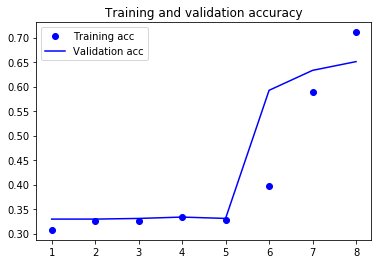

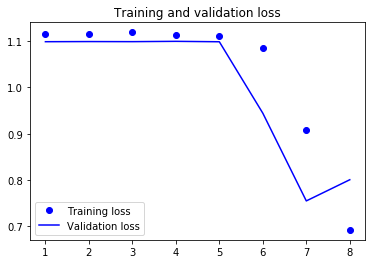

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

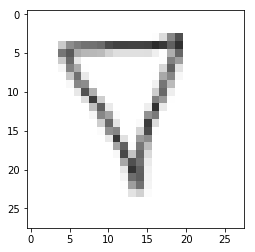

(1, 28, 28, 3)


In [21]:
img_path = 'test_set/triangles/drawing(99).png'

img = image.load_img(img_path, target_size=(28, 28))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

print(img_tensor.shape)

In [22]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = classifier.predict_classes(images, batch_size=10)
print("Predicted class is:",classes)

Predicted class is: [0]


In [23]:
layer_outputs = [layer.output for layer in classifier.layers[:12]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=classifier.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [24]:
activations = activation_model.predict(img_tensor) # Returns a list of five Numpy arrays: one array per layer activation

In [25]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 28, 28, 32)


In [26]:
second_layer_activation = activations[1]
print(second_layer_activation.shape)

(1, 26, 26, 32)


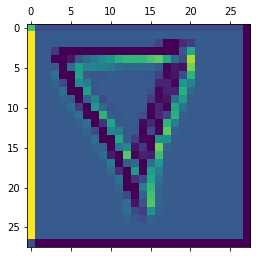

In [30]:
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')

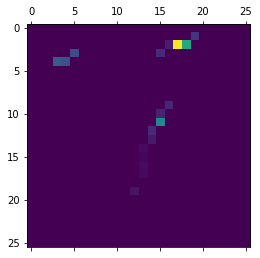

In [37]:
plt.matshow(second_layer_activation[0, :, :, 11], cmap='viridis')

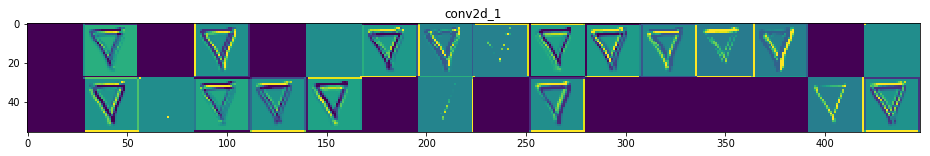

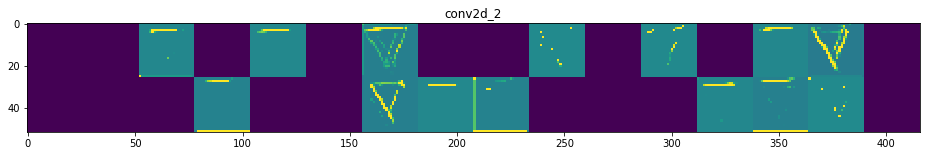

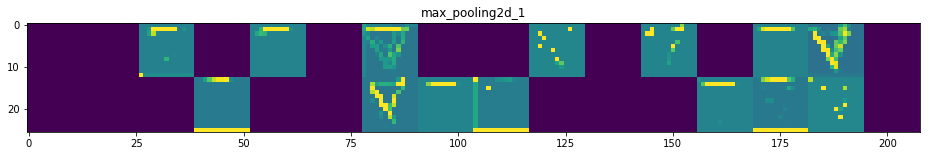

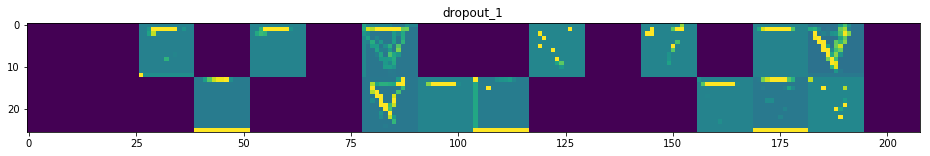

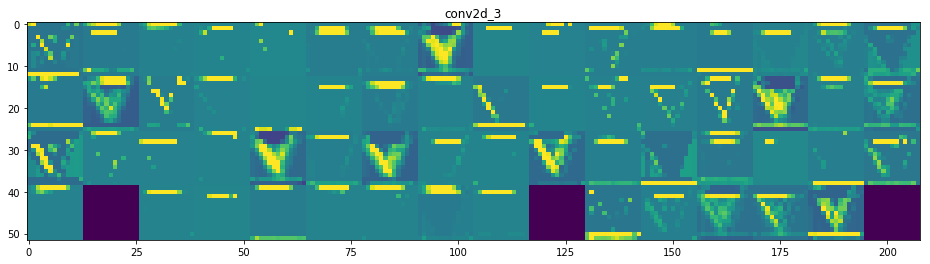

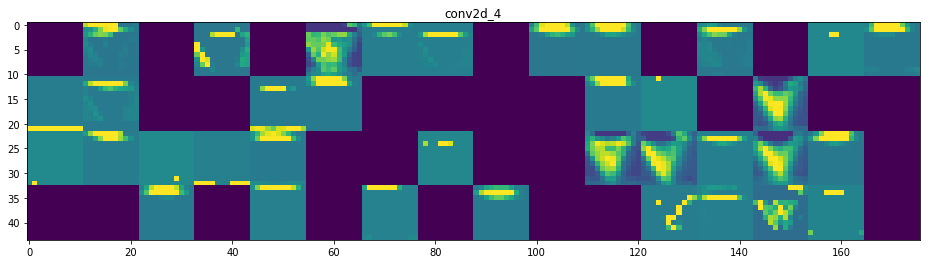

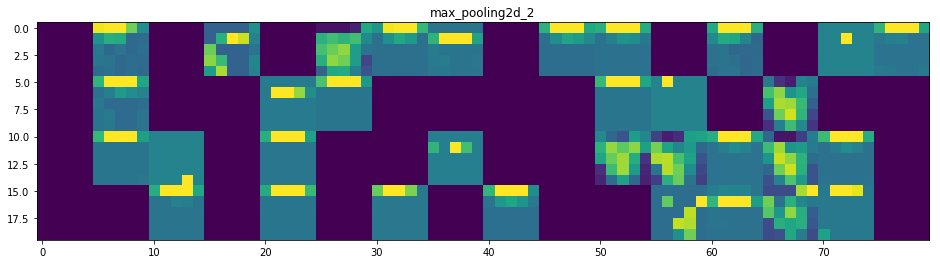

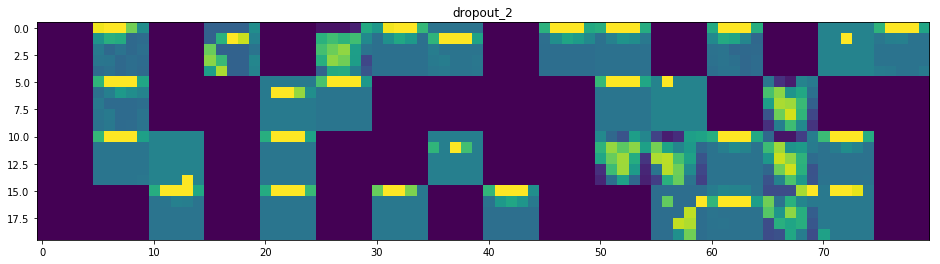

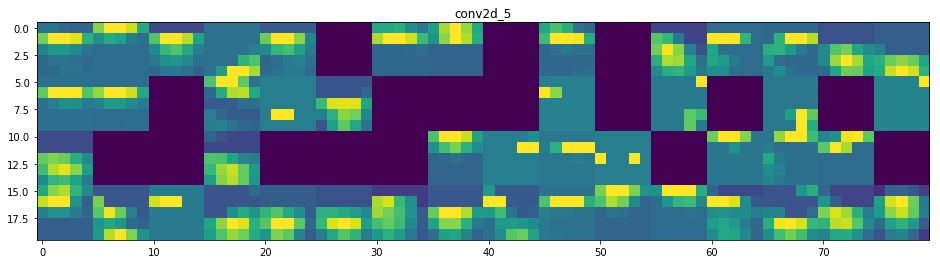

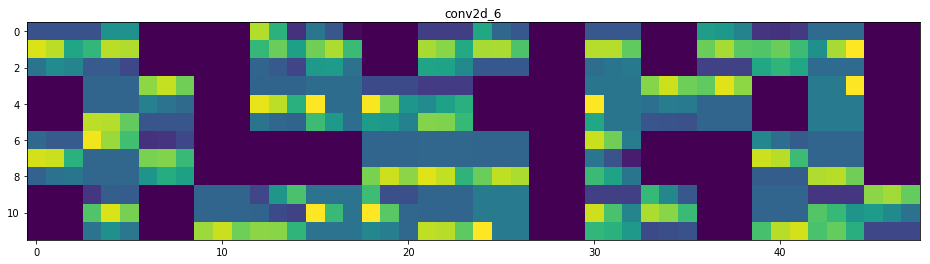

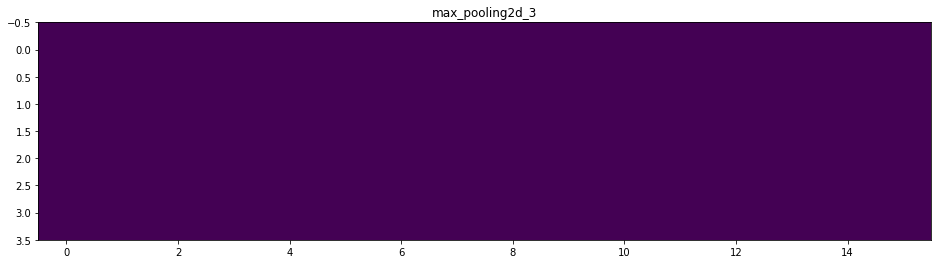

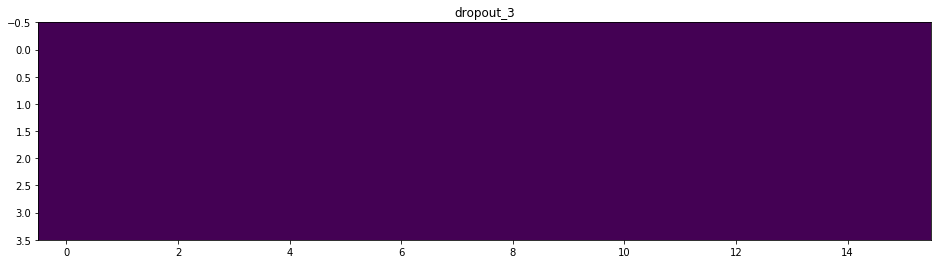

In [34]:
layer_names = []
for layer in classifier.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')